In [5]:

from typing import TypedDict, Optional, Dict, Any, List
from langchain_core.tools import tool
from langchain_ollama import ChatOllama
import re
import requests
import json
import dotenv
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import display, Markdown, Image
import os
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.prebuilt import create_react_agent
from langchain_core.output_parsers import StrOutputParser, BaseOutputParser, PydanticOutputParser, JsonOutputParser
from pydantic import BaseModel, Field, model_validator
import ollama
from pathlib import Path
import pandas as pd
from datetime import datetime
dotenv.load_dotenv()
OPEN_WEATHER_API_KEY = os.getenv("OPEN_WEATHER_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")



### Get downloaded models

In [2]:
ollama_models = ollama.list()
models = {}
for model in ollama_models['models']:
    # get simple model name
    model_name = model['model'].split('/')[-1]
    # remove version after .
    model_name = re.sub(r'\.\d+', '', model_name).replace(":latest", "")

    models[model_name] = {
        "name": model['model'],
        "parameters": model.details.parameter_size

    }
models

# create a dataframe with model_name, model, and parameters
df = pd.DataFrame(models).T
df = df.reset_index()
df.columns = ['model_name', 'model', 'parameters']
df

,model_name,model,parameters
0,llama3,llama3.1:latest,8.0B
1,codellama:7b,codellama:7b,7B
2,llama3-uncensored,artifish/llama3.2-uncensored:latest,3.6B
3,llama2-uncensored,llama2-uncensored:latest,7B
4,tinyllama,tinyllama:latest,1B
5,llama3:3b,llama3.2:3b,3.2B


## AgentExecutor (LangGraph)

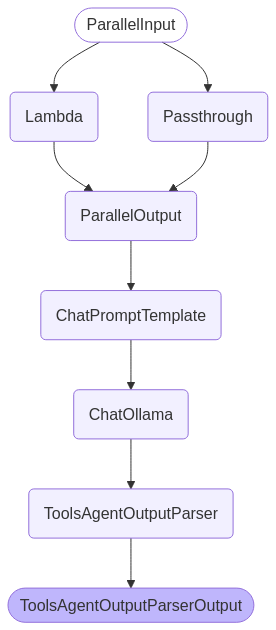

In [6]:

from langchain_community.tools import TavilySearchResults
from langchain.agents import  create_tool_calling_agent

llm = ChatOllama(
    model=models['llama3:3b']['name'],
    temperature=0.5
)

prompt = ChatPromptTemplate.from_messages(
    messages=[
    ("system", """You are a helpful AI assistant that answers questions precisely."""), 
    MessagesPlaceholder(variable_name='chat_history'),
    ("user", "{prompt}"), 
    MessagesPlaceholder(variable_name='agent_scratchpad')

])

tools = [TavilySearchResults(max_results=2)]

agent = create_tool_calling_agent(llm, tools, prompt=prompt)

display(Image(agent.get_graph().draw_mermaid_png()))